### Notes

For downloading a dataset kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
https://www.kaggle.com/docs/api

https://www.youtube.com/watch?v=P47raNuzAW0

### Libaries

In [1]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
import nltk
import ssl
import certifi
from sklearn.model_selection import train_test_split


### SSL for download NLTK stopwords

In [2]:
# Define a function to create an SSL context for HTTPS connections
def create_ssl_context():
    context = ssl.create_default_context(cafile=certifi.where())
    return context

# Set the default HTTPS context to use the SSL context created by the new function
ssl._create_default_https_context = create_ssl_context

# Now attempt to download the NLTK stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mitsoufortunat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Import Data

In [3]:
df = pd.read_csv("IMDB Dataset.csv")

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Simple EDA

<BarContainer object of 2 artists>

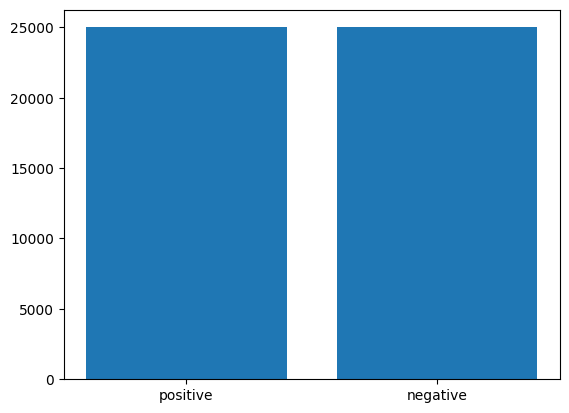

In [38]:
plt.bar(['positive', 'negative'], df.sentiment.value_counts().to_numpy())

### Building the Word embeddor using Gensim

In [148]:
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec

In [149]:
def tokenizer(sentence):
    tokenized_text = simple_preprocess(sentence, deacc=True)
    stemmed_tokens = [porter_stemmer.stem(word) for word in tokenized_text]
    return stemmed_tokens

In [150]:
df['stemmed_tokens'] = df['review'].apply(tokenizer)

In [151]:
#stemmed_tokens = pd.Series(df['stemmed_tokens']).values
w2v_model = Word2Vec(df['stemmed_tokens'], min_count = 1)

In [152]:
w2v_model.save('w2v.model')
w2v_model = Word2Vec.load('w2v.model')

In [153]:
def sent_vec(sent):
    vector_size =w2v_model.wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in w2v_model.wv:
            ctr += 1
            wv_res += w2v_model.wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [154]:
df['vec'] = df['stemmed_tokens'].apply(sent_vec)


In [155]:
X_train, X_test, Y_train, Y_test = train_test_split(df['vec'].to_list(), 
                                                    df['sentiment'],
                                                    test_size=0.3)

In [156]:
X_train

[array([-0.20522844,  0.19113564,  0.55609386,  0.54462035, -0.11527322,
         0.18960544,  0.18290257, -0.53082201, -0.832998  ,  0.41558406,
         0.64587654,  0.64385044, -0.1025009 ,  0.0680177 ,  0.09337085,
         0.31941983, -0.30065475,  0.2775899 , -0.2896532 ,  0.52505648,
        -0.09334626, -0.50870269, -0.14903604,  0.69873897, -0.4974179 ,
         0.94415771,  0.58202204,  0.08748516,  0.43228144,  0.19093883,
        -0.81621886, -0.49254278, -0.53302815,  0.85329052,  0.60041117,
        -0.40042442, -0.33838795, -0.10773457,  0.6640869 , -0.07024874,
        -0.14297142,  0.1212316 ,  0.42521966,  0.28787246,  0.51993165,
         0.21068484,  0.01928996,  0.06439929, -0.17652345, -0.79972743,
        -0.25859276,  0.11019045,  0.22326566, -1.0143728 , -0.22961799,
         0.5058607 ,  0.70971866,  0.18018707, -0.14722725, -0.40111748,
         0.5460482 ,  0.61281291, -0.46533438, -0.29852802,  0.23596497,
        -0.52161434, -0.36274407,  0.29875523,  0.4

### Modeling

In [157]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

clf_decision_word2vec = DecisionTreeClassifier()
clf_decision_word2vec.fit(X_train, Y_train)


DecisionTreeClassifier()

In [166]:
predicted = clf_decision_word2vec.predict(X_test)

In [169]:
print("DecisionTree Accuracy:",metrics.accuracy_score(Y_test, predicted))

DecisionTree Accuracy: 0.7133333333333334


In [160]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train,Y_train)
from sklearn import metrics
predicted = classifier.predict(X_test)
print("Logistic Regression Accuracy:",metrics.accuracy_score(Y_test, predicted))


LogisticRegression()

### Predict a new sentence

In [176]:
your_sentence = "I love you"

In [177]:
sentence_clean = sent_vec(tokenizer(your_sentence))
predicted = classifier.predict(sentence_clean.reshape(1, -1))
print("The sentence your wrote is predicted as being " + str(predicted))

The sentence your wrote is predicted as being ['positive']
